<a href="https://colab.research.google.com/github/logicalschema/data620/blob/main/Final%20Project/Data_620_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data 620 Final Project

[Github Link](https://github.com/logicalschema/data620/blob/main/Final%20Project/)

[YouTube Video](https://youtu.be/s28QmvUUKUc)  

<img src=https://github.com/logicalschema/data620/raw/main/Final%20Project/data/boroughs.jpg width="300">





## Assignment
My purpose for this project is to study if there is an observable correlation between NYC's Department of Building approved permits and property values. My hypothesis is that where there is an observable correlation between the type of permits and the property value of the borough. This would encompass network theory by looking at boroughs as nodes and plotting this information with string patterns in the permits from the Department of Buildings.

First and foremost, New York City is where I live and have lived all of my life. NYC consists of 5 boroughs: Brooklyn (Kings County), Queens (Queens County), Staten Island (Richmond County), Manhattan (New York County), and the Bronx (Bronx County). My interest in this project is purely selfish as I wanted to see how property values could be impacted in the future.

Specifically, I looked at 2019 for the boroughs because 2020 to the present would be outliers considering the pandemic.

## Data Sources

My two primary sources are:

### Zillow

Zillow provides free information with regards to property values. This [link](https://files.zillowstatic.com/research/public_v2/zhvi/Metro_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_mon.csv?t=1621600951) is where I went to get data for values. Now, Zillow does make the error at times to not segregate the data enough to differentiate the boroughs from one another. So in cleaning and organizing the data, I gathered the zip code data and `CountyName` field to differentiate each borough.

A copy of the original data is also available at this [link](https://github.com/logicalschema/data620/raw/main/Final%20Project/data/Zip_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_mon.csv.gz) on my Github

### NYC OpenData
This is NYC's massive data platform. This [link](https://data.cityofnewyork.us/Housing-Development/DOB-NOW-Build-Approved-Permits/rbx6-tga4) is where I went to gather the data for the Department of Buildings' permit data. Some of the data was inaccurate. This data will be scoured for strings using NLTK. 

A copy of the OpenData that was acquired is also available at this [link](https://github.com/logicalschema/data620/raw/main/Final%20Project/data/DOB_NOW__Build___Approved_Permits.csv.gz).


### Organizing and Cleanup
I worked on the files and have organized them into csv files for use in this project.

### Setup
The following block sets up the libraries and data for use in this prohject.

In [203]:
import pandas as pd
import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

# Networkx
import networkx as nx
import networkx.algorithms.bipartite as bipartite

from html import unescape

# NLTK
# Used for various language features
import nltk
from nltk import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.classify import apply_features

# Sentiment Analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

# Downloads for use in detecting stopwords
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words("english"))



# The Five Boroughs
# Brooklyn (Kings County)
# Queens (Queens County)
# Staten Island (Richmond County)
# Manhattan (New York County)
# Bronx (Bronx County)

# Counter for Figures
fig_no = 1

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [204]:
# Setup of Zillow data set: zipcode (RegionName) and borough (CountyName) 
zillow_nyc2019_df = pd.read_csv('https://raw.githubusercontent.com/logicalschema/data620/main/Final%20Project/data/zillow_ny.csv')
zillow_nyc2019_df.head(5)

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31
0,61639,0,10025,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,1083891.0,1095244.0,1116158.0,1110777.0,1110752.0,1100678.0,1081990.0,1056843.0,1052388.0,1056984.0,1068839.0,1065266.0
1,61637,2,10023,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,1135281.0,1109912.0,1109211.0,1096399.0,1094837.0,1090185.0,1090223.0,1083327.0,1062489.0,1056177.0,1064622.0,1090206.0
2,61616,6,10002,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,982881.0,995844.0,1010738.0,1000755.0,1000298.0,1008917.0,1022677.0,1024317.0,1015084.0,1014887.0,1012636.0,1037946.0
3,62037,10,11226,Zip,NY,NY,New York,New York-Newark-Jersey City,Kings County,627655.0,642478.0,659393.0,668787.0,666941.0,662393.0,656451.0,648913.0,647485.0,637022.0,627307.0,614754.0
4,61807,11,10467,Zip,NY,NY,New York,New York-Newark-Jersey City,Bronx County,169886.0,171180.0,172950.0,174116.0,174988.0,175537.0,177673.0,179822.0,184652.0,189184.0,191028.0,191290.0


In [205]:
# Setup of DOB data
dob_2019_df = pd.read_csv('https://github.com/logicalschema/data620/raw/main/Final%20Project/data/dob_issue_2019_permits.csv.gz')
dob_2019_df.head()


,Job Filing Number,Filing Reason,House No,Street Name,Borough,LOT,Bin,Block,C B NO,Apt/Condo No(s),Work on Floor,Work Type,Permittee's License Type,Applicant License #,Applicant First Name,Applicant Middle Name,Applicant Last Name,Applicant Business Name,Applicant Business Address,Filing Representative First Name,Filing Representative Middle Initial,Filing Representative Last Name,Filing Representative Business Name,Work Permit,Approved Date,Issued Date,Expired Date,Job Description,Estimated Job Costs,Owner Business Name,Owner Name,Owner Street Address,Owner City,Owner State,Owner Zip Code
0,Q00265100-I1,Initial Permit,59-41,MYRTLE AVENUE,QUEENS,61.0,4084150,3509,405.0,NaN,Ground Floor,Sign,S,166,JAMES,NaN,MAUCERI,"MAUCERI SIGN CO., INC",167-25 ROCKAWAY BLVD,NaN,NaN,NaN,NaN,Q00265100-I1-SG,2019-12-05 15:17:00,2019-12-05 00:00:00,2020-09-16 04:00:00,ERECT AN ILLUMINATED BUSINESS,1287.0,NaN,TONY ZADEH,NaN,NaN,NaN,NaN
1,M00222854-I1,Initial Permit,315,WEST 23 STREET,MANHATTAN,28.0,1013456,747,104.0,NaN,Floor Number(s) 002 through 002,Plumbing,P,2378,SHALLAN,NaN,HADDAD,HP SERVICES INC,"470 CONVENT AVENUE, SUITE 2",MEI XIA,NaN,HUANG,ZHENG & ASSOCIATES LLC,M00222854-I1-PL,2019-09-11 00:00:00,2019-09-11 00:00:00,2020-01-22 00:00:00,PLUMBING WORK @ 2ND. FLOOR UNI,23200.0,NaN,TONY SHEK YIN WONG,NaN,NaN,NaN,NaN
2,B00118086-I1,Initial Permit,574,WASHINGTON AVENUE,BROOKLYN,56.0,3057580,2012,302.0,NaN,Ope 1 thru 1,Construction Fence,GC,612865,SEWERYN,NaN,GRZYWNA,NaN,17 WOODHILL CT,NaN,NaN,NaN,NaN,B00118086-I1-FN,2019-01-11 00:00:00,2019-01-11 00:00:00,2020-01-11 00:00:00,Respectfully request to instal,500.0,CHRISTOPHER DIERIG,DIERIG CHRISTOPHER,NaN,NaN,NaN,NaN
3,M00064078-I1,Renewal Permit Without Changes,88,WALKER STREET,MANHATTAN,24.0,1809790,196,101.0,NaN,"Ope 001 thru 009, Ope 002 thru 009",Supported Scaffold,GC,620022,EDWARD,NaN,KELLY,CONSOLIDATED SCAFFOLDING,3969 MERRITT AVE,JAMES,NaN,O'SHEA,EUROCELT EXPEDITING,M00064078-I1-SF,2018-07-23 00:00:00,2019-06-26 00:00:00,2020-08-06 00:00:00,INSTALLATION OF A PIPE SCAFFOL,5000.0,CONSOLIDATED SCAFFOLD & BRIDGE,TOM BOWES,NaN,NaN,NaN,NaN
4,Q00265110-I1,Initial Permit,59-41,MYRTLE AVENUE,QUEENS,61.0,4084150,3509,405.0,NaN,Ground Floor,Sign,S,166,JAMES,NaN,MAUCERI,"MAUCERI SIGN CO., INC",167-25 ROCKAWAY BLVD,GINA MARIE,NaN,MAUCERI,MAUCERI SIGN CO.,Q00265110-I1-SG,2019-12-06 00:00:00,2019-12-06 00:00:00,2020-09-16 04:00:00,ERECT AN ILLUMINATED BUSINESS,1287.0,NaN,TONY ZADEH,NaN,NaN,NaN,NaN


### Visual Analysis
Here is what some of the data looks like.

In [206]:
# Unique Work types for the DOB permits
print(dob_2019_df['Work Type'].unique())

['Sign' 'Plumbing' 'Construction Fence' 'Supported Scaffold'
 'Sidewalk Shed' 'Sprinklers' 'Curb Cut' 'Mechanical Systems' 'Structural'
 'Boiler Equipment' 'Standpipe' 'Antenna']


In [207]:
# Look at Job Descriptions for the DOB permits
print(dob_2019_df['Job Description'].tail(10))

42058    HEREBY FILING TO REPLACE EXHAU
42059    PROPOSED INSTALLATION OF HEAVY
42060    installation of temporary cons
42061    Modifications to existing plum
42062    INSTALLATION OF TEMPORARY HEAV
42063     INSTALLATION OF PIPE SCAFFOLD
42064     Additions/modifications to an
42065    INSTALLATION OF TEMPORARY CONS
42066    PROPOSED TEMPORARY CONSTRUCTIO
42067    Install temporary construction
Name: Job Description, dtype: object


In [208]:
# Gather the unique work types
work_types = dob_2019_df['Work Type'].unique()

# Gather the Borough names
dob_boroughs = dob_2019_df['Borough'].unique()

dob_2019_df.groupby(by='Borough').agg('count')



,Job Filing Number,Filing Reason,House No,Street Name,LOT,Bin,Block,C B NO,Apt/Condo No(s),Work on Floor,Work Type,Permittee's License Type,Applicant License #,Applicant First Name,Applicant Middle Name,Applicant Last Name,Applicant Business Name,Applicant Business Address,Filing Representative First Name,Filing Representative Middle Initial,Filing Representative Last Name,Filing Representative Business Name,Work Permit,Approved Date,Issued Date,Expired Date,Job Description,Estimated Job Costs,Owner Business Name,Owner Name,Owner Street Address,Owner City,Owner State,Owner Zip Code
Borough,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
BRONX,3936,3936,3936,3936,3935,3936,3936,3933,72,3936,3936,3936,3936,3936,14,3936,3924,3934,2082,0,2082,2073,3936,3936,3936,3936,3936,3936,3831,3936,0,0,0,0
BROOKLYN,11413,11413,11413,11413,11407,11413,11413,11405,168,11412,11413,11413,11413,11413,34,11413,11350,11391,6420,0,6420,6394,11413,11411,11413,11413,11413,11412,10895,11413,0,0,0,0
MANHATTAN,17683,17683,17683,17683,17661,17683,17683,17678,241,17683,17683,17683,17683,17683,17,17683,17626,17672,11024,0,11024,10950,17683,17678,17683,17683,17683,17682,17002,17682,0,0,0,0
QUEENS,7080,7080,7080,7080,7079,7080,7080,7076,83,7080,7080,7080,7080,7080,9,7080,7038,7068,3477,0,3477,3455,7080,7080,7080,7080,7080,7080,6476,7080,0,0,0,0
STATEN ISLAND,1956,1956,1956,1956,1956,1956,1956,1955,13,1956,1956,1956,1956,1956,0,1956,1949,1950,839,0,839,837,1956,1956,1956,1956,1956,1956,1876,1956,0,0,0,0


Overall, Manhattan has the highest number of permits issued in 2019 with the number of 17,683. Brooklyn is second with 11,413 and followed by Queens, the Bronx, and Staten Island.

In [209]:
dob_2019_df.groupby(by='Work Type').agg('count')


,Job Filing Number,Filing Reason,House No,Street Name,Borough,LOT,Bin,Block,C B NO,Apt/Condo No(s),Work on Floor,Permittee's License Type,Applicant License #,Applicant First Name,Applicant Middle Name,Applicant Last Name,Applicant Business Name,Applicant Business Address,Filing Representative First Name,Filing Representative Middle Initial,Filing Representative Last Name,Filing Representative Business Name,Work Permit,Approved Date,Issued Date,Expired Date,Job Description,Estimated Job Costs,Owner Business Name,Owner Name,Owner Street Address,Owner City,Owner State,Owner Zip Code
Work Type,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Antenna,975,975,975,975,975,975,975,975,975,1,974,975,975,975,0,975,974,975,937,0,937,937,975,975,975,975,975,975,952,975,0,0,0,0
Boiler Equipment,293,293,293,293,293,293,293,293,287,0,293,293,293,293,0,293,292,293,85,0,85,84,293,293,293,293,293,293,269,293,0,0,0,0
Construction Fence,9561,9561,9561,9561,9561,9558,9561,9561,9554,170,9561,9561,9561,9561,0,9561,9480,9520,4452,0,4452,4439,9561,9561,9561,9561,9561,9561,8845,9561,0,0,0,0
Curb Cut,724,724,724,724,724,724,724,724,724,14,724,724,724,724,0,724,721,721,268,0,268,267,724,724,724,724,724,724,667,724,0,0,0,0
Mechanical Systems,2191,2191,2191,2191,2191,2187,2191,2191,2190,0,2191,2191,2191,2191,0,2191,2190,2189,1449,0,1449,1443,2191,2191,2191,2191,2191,2190,2065,2190,0,0,0,0
Plumbing,4487,4487,4487,4487,4487,4480,4487,4487,4487,10,4487,4487,4487,4487,0,4487,4448,4487,2040,0,2040,1953,4487,4487,4487,4487,4487,4487,3833,4487,0,0,0,0
Sidewalk Shed,11602,11602,11602,11602,11602,11601,11602,11602,11597,238,11602,11602,11602,11602,55,11602,11585,11600,6669,0,6669,6669,11602,11598,11602,11602,11602,11602,11480,11602,0,0,0,0
Sign,3438,3438,3438,3438,3438,3433,3438,3438,3436,28,3438,3438,3438,3438,0,3438,3432,3438,2389,0,2389,2389,3438,3438,3438,3438,3438,3437,3326,3438,0,0,0,0
Sprinklers,1667,1667,1667,1667,1667,1661,1667,1667,1667,2,1667,1667,1667,1667,0,1667,1653,1667,827,0,827,806,1667,1667,1667,1667,1667,1667,1620,1667,0,0,0,0


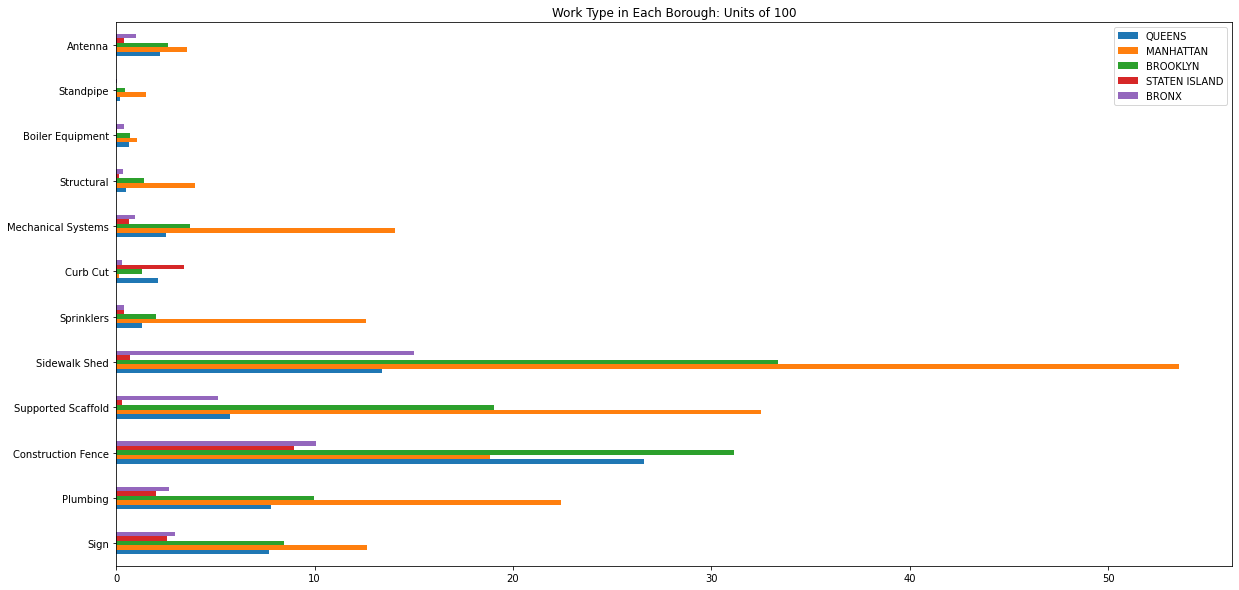

In [210]:
#work_types
#dob_boroughs = dob_2019_df['Borough'].unique()
worktypeCounts = {}
for borough in dob_boroughs:
  worktypeCounts[borough] = {}
  for worktype in work_types:
    worktypeCounts[borough][worktype] = len(dob_2019_df[(dob_2019_df['Borough'] == borough) & (dob_2019_df['Work Type'] == worktype)].index)/100


t = pd.DataFrame(worktypeCounts)
t.plot.barh(figsize=(20,10))

plt.title('Work Type in Each Borough: Units of 100')
plt.savefig('Figure ' + str(fig_no) + '.png')
fig_no += 1

With an initial view of the number of permits issued, Manhattan stands out for overall permits except for the Construction Fence permit. This type of permit for 2019 seemed prevalent in Brooklyn.

****
Next, let's look at the Zillow data. Each row in the data set consists of a zip code and the *Zillow Home Value Index (ZHVI): A smoothed, seasonally adjusted measure of the typical home value and market changes across a given region and housing type* for each month of 2019. The following is a plot of that data for the average ZHVI per borough.

In [211]:
# Lookup the borough by the CountyName
borough_lookup = {'BROOKLYN': 'Kings County', 'QUEENS': 'Queens County', 'STATEN ISLAND': 'Richmond County', 'MANHATTAN': 'New York County', 'BRONX': 'Bronx County'}

# Reverse lookup of value to corresponding DOB borough identifier
def boroughLookup(boro):
  all_keys = [key for key, value in borough_lookup.items() if value == boro]
  if len(all_keys) == 0:
    return 'Invalid boro value'
  else:
    return all_keys[0]

borough_mean = zillow_nyc2019_df.groupby('CountyName').mean()
borough_mean = borough_mean.drop(columns=['RegionID', 'SizeRank', 'RegionName'])
borough_mean = borough_mean / 100000
borough_mean


,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31
CountyName,,,,,,,,,,,,
Bronx County,3.262802,3.294673,3.339014,3.378183,3.394806,3.403873,3.418797,3.440813,3.455539,3.474596,3.482932,3.511142
Kings County,7.726822,7.739735,7.768570,7.783488,7.801928,7.798827,7.794559,7.761707,7.753244,7.736102,7.705746,7.674865
New York County,10.927544,10.860680,10.830599,10.745599,10.693777,10.630276,10.620732,10.565381,10.495479,10.407393,10.366868,10.355041
Queens County,5.649925,5.667326,5.680575,5.683751,5.687567,5.684476,5.678457,5.671154,5.653888,5.651528,5.640890,5.638413
Richmond County,5.556085,5.555509,5.529226,5.500547,5.481162,5.474113,5.470397,5.456541,5.466299,5.459841,5.451462,5.427036


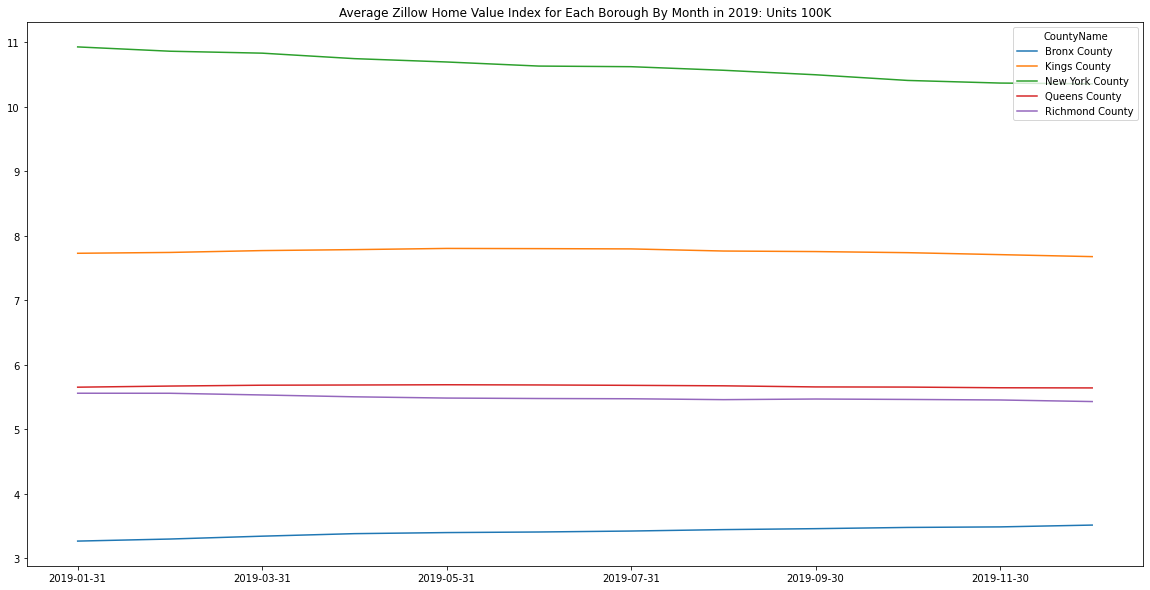

In [212]:
borough_mean.T.plot.line(figsize=(20,10))
plt.title('Average Zillow Home Value Index for Each Borough By Month in 2019: Units 100K')
plt.savefig('Figure ' + str(fig_no) + '.png')
fig_no += 1


On average, Manhattan (New York County) has the highest ZHVI value as a borough for 2019. 

Let's revisit the `zillow_nyc2019_df` and look at the zip codes with the maximum and minimum ZHVI values for each month in 2019.

In [213]:
dates = zillow_nyc2019_df.columns[9:]

for date in dates:
  temp = zillow_nyc2019_df[zillow_nyc2019_df[date]==zillow_nyc2019_df[date].max()]
  zip = temp['RegionName'].values[0]
  countyName = boroughLookup(temp['CountyName'].values[0])
  print("The zip code with the maximum value for " + date + " is " + str(zip) + " of " + countyName.lower().capitalize())

for date in dates:
  temp = zillow_nyc2019_df[zillow_nyc2019_df[date]==zillow_nyc2019_df[date].min()]
  zip = temp['RegionName'].values[0]
  countyName = boroughLookup(temp['CountyName'].values[0])
  print("The zip code with the minimum value for " + date + " is " + str(zip) + " of " + countyName.lower().capitalize())


The zip code with the maximum value for 2019-01-31 is 10013 of Manhattan
The zip code with the maximum value for 2019-02-28 is 10013 of Manhattan
The zip code with the maximum value for 2019-03-31 is 10013 of Manhattan
The zip code with the maximum value for 2019-04-30 is 10013 of Manhattan
The zip code with the maximum value for 2019-05-31 is 10013 of Manhattan
The zip code with the maximum value for 2019-06-30 is 10013 of Manhattan
The zip code with the maximum value for 2019-07-31 is 10013 of Manhattan
The zip code with the maximum value for 2019-08-31 is 10013 of Manhattan
The zip code with the maximum value for 2019-09-30 is 10013 of Manhattan
The zip code with the maximum value for 2019-10-31 is 10013 of Manhattan
The zip code with the maximum value for 2019-11-30 is 10013 of Manhattan
The zip code with the maximum value for 2019-12-31 is 10013 of Manhattan
The zip code with the minimum value for 2019-01-31 is 10462 of Bronx
The zip code with the minimum value for 2019-02-28 is 1

The zip code 10013 throughout 2019 had the highest Zillow value whereas the zip codes 10462 and 10467 had the lowest. To have an idea of where these zip codes are I have attached where they are on Google Maps.

**10013**  

<img src=https://github.com/logicalschema/data620/raw/main/Final%20Project/data/10013.png width="300">

**10462**  

<img src=https://github.com/logicalschema/data620/raw/main/Final%20Project/data/10462.png width="300">

**10467**  

<img src=https://github.com/logicalschema/data620/raw/main/Final%20Project/data/10467.png width="300">

****
Now, let's look at a network graph of the Zillow data.

In [214]:
# Initialize the Graph
G = nx.Graph()

# Create the nodes
G.add_nodes_from(dob_boroughs, bipartite='borough')
## Zip codes with average zhvi value for 2019
## Adding Mean column to zillow df
zillow_nyc2019_df['Mean'] = zillow_nyc2019_df.iloc[:, 9:].mean(axis=1)
zip_nodes = []
zips = []
for index in zillow_nyc2019_df.index:
  attribute_dict = {}
  zip = zillow_nyc2019_df['RegionName'][index]
  attribute_dict['boro'] = boroughLookup(zillow_nyc2019_df['CountyName'][index])
  attribute_dict['avg'] = zillow_nyc2019_df['Mean'][index]
  zip_nodes.append( (zip, attribute_dict) )
  zips.append(zip)

## Add zip code nodes
G.add_nodes_from(zip_nodes, bipartite='zipcode')


# Create the edges
for element in zip_nodes:
  G.add_edge(element[0], element[1]['boro'])




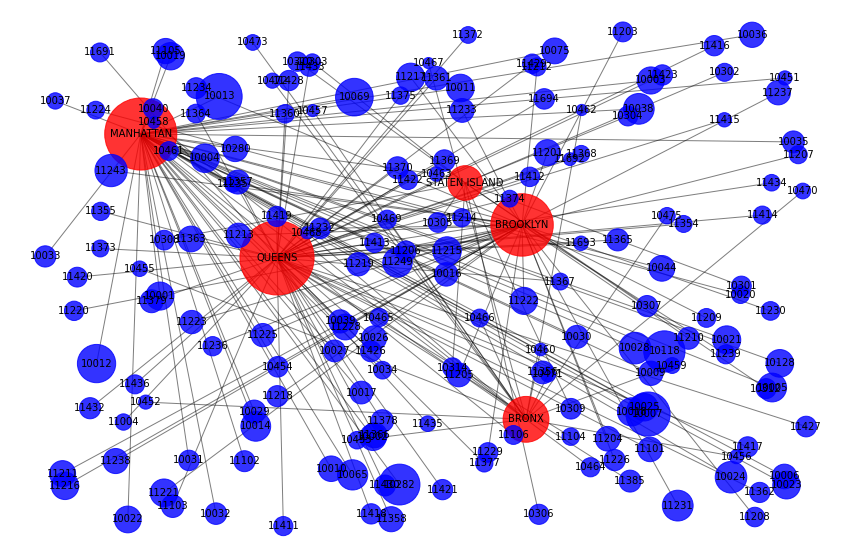

In [215]:
plt.figure(fig_no,figsize=(15,10)) 
plt.axis('off')

# Calculate the degree centrality
boroDegree = nx.degree(G, dob_boroughs) 

# node_size for zip codes
zipSize = []
for element in zip_nodes:
  zipSize.append( (element[0], element[1]['avg'] / 100000)  )

pos = nx.random_layout(G)
# nodes
nx.draw_networkx_nodes(G,pos,
                       nodelist=dob_boroughs,
                       node_color='red',
                       node_size=[v * 100 for v in dict(boroDegree).values()],
                       alpha=0.8
                       )
nx.draw_networkx_nodes(G,pos,
                       nodelist=zips,
                       node_color='blue',
                       node_size=[v * 70 for v in dict(zipSize).values()],
                       alpha=0.8
                       )
nx.draw_networkx_edges(G, pos, width=1, alpha=0.5)
labels = nx.draw_networkx_labels(G, pos, font_size=10)
plt.savefig('Figure ' + str(fig_no) + '.png')
fig_no += 1

## NLTK

Next, I will use the `NLTK` package to examine the DOB permit language to see if I can uncover any nuggets, specifically, the `Job Description` field for each borough.

In [216]:
print(dob_boroughs)

['QUEENS' 'MANHATTAN' 'BROOKLYN' 'STATEN ISLAND' 'BRONX']


In [217]:
# Function tokenizer
# Tokenizes a text variable. Converts words to lowercase and removes stop words
def quickTokenizer(textVar):
  tokens = word_tokenize(textVar)

  # Lowercase the tokens
  tokens_l = [w.lower() for w in tokens if w.isalpha()]

  filtered = []

  for w in tokens_l:
    if w not in stop_words:
      filtered.append(w)

  return filtered

brooklynText = ""
queensText = ""
statenislandText = ""
manhattanText = ""
bronxText = ""

#dob_boroughs = dob_2019_df['Borough'].unique()
for boro in dob_boroughs:
  for index, row in dob_2019_df[dob_2019_df['Borough'] == boro].iterrows():

   if boro == 'BROOKLYN':
     brooklynText = brooklynText + row['Job Description'] + " "
   elif boro == 'QUEENS':
     queensText = queensText + row['Job Description'] + " "
   elif boro == 'STATEN ISLAND':
     statenislandText = statenislandText + row['Job Description'] + " "
   elif boro == 'MANHATTAN':
     manhattanText = manhattanText + row['Job Description'] + " "
   elif boro == 'BRONX':
     bronxText = bronxText + row['Job Description'] + " "


In [218]:
# Create the corpus for each Borough and make frequency distributions

corpusBrooklyn = quickTokenizer(brooklynText)
freqBrooklyn = FreqDist(corpusBrooklyn)

corpusQueens = quickTokenizer(queensText)
freqQueens = FreqDist(corpusQueens)

corpusStatenIsland = quickTokenizer(statenislandText)
freqStatenIsland = FreqDist(corpusStatenIsland)

corpusManhattan = quickTokenizer(manhattanText)
freqManhattan = FreqDist(corpusManhattan)

corpusBronx = quickTokenizer(bronxText)
freqBronx = FreqDist(corpusBronx)

**Top Brooklyn Job Description Words**

In [219]:
topBrooklyn = pd.DataFrame(freqBrooklyn.most_common(100),columns=['Word','Frequency'])
topBrooklyn.head(10)

,Word,Frequency
0,installation,6224
1,temporary,2185
2,fence,1431
3,proposed,1423
4,construction,1283
5,heavy,1255
6,sidewalk,1200
7,shed,1085
8,install,839
9,illuminated,636


**Top Queens Job Description Words**

In [220]:
topQueens = pd.DataFrame(freqQueens.most_common(100),columns=['Word','Frequency'])
topQueens.head(10)

,Word,Frequency
0,installation,2607
1,temporary,1651
2,construction,1210
3,fence,1039
4,install,803
5,proposed,658
6,illuminated,587
7,heavy,552
8,erect,432
9,new,411


**Top Staten Island Job Description Words**

In [221]:
topStatenIsland = pd.DataFrame(freqStatenIsland.most_common(100),columns=['Word','Frequency'])
topStatenIsland.head(10)

,Word,Frequency
0,installation,421
1,construction,385
2,fence,330
3,curb,279
4,filed,253
5,cut,248
6,illuminated,212
7,temporary,196
8,proposed,190
9,application,189


**Top Manhattan Job Description Words**

In [222]:
topManhattan = pd.DataFrame(freqManhattan.most_common(100),columns=['Word','Frequency'])
topManhattan.head(10)

,Word,Frequency
0,installation,9918
1,temporary,2656
2,heavy,2265
3,sidewalk,1811
4,shed,1626
5,duty,1488
6,plumbing,1382
7,proposed,1372
8,scaffold,1308
9,sid,1260


**Top Bronx Job Description Words**

In [223]:
topBronx = pd.DataFrame(freqBronx.most_common(100),columns=['Word','Frequency'])
topBronx.head(10)

,Word,Frequency
0,installation,2397
1,temporary,940
2,heavy,621
3,proposed,489
4,sidewalk,431
5,construction,305
6,shed,302
7,fence,292
8,duty,284
9,install,284


An observation is that across the boroughs installation, temporary, heavy, and sidewalk words appeared. Manhattan has a large frequency of building permits and in general more projects. Queens is notable for `new` being in the top word list. Manhattan is notable for the plumbing keyword. Perhaps, plumbing is an especially important trade in Manhattan.

## Sentiment Analysis

Next, I will run sentiment analysis on the job descriptions for each borough.

In [224]:
# Downloads for use in sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

# Declaration of functions for sentiment analysis

def sentimentAnalysis(text):
  sia = SentimentIntensityAnalyzer()
  temp = sia.polarity_scores(text)

  return temp

def sanitizeText(text):
  words = []

  # Remove punctuation from the text
  temp = text.translate(str.maketrans('', '', string.punctuation))

  return temp.lower()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [225]:
print("Brooklyn")
print(sentimentAnalysis(brooklynText))
print("\n")

print("Queens")
print(sentimentAnalysis(queensText))
print("\n")

print("Staten Island")
print(sentimentAnalysis(statenislandText))
print("\n")

print("Manhattan")
print(sentimentAnalysis(manhattanText))
print("\n")

print("Bronx")
print(sentimentAnalysis(bronxText))
print("\n")

Brooklyn
{'neg': 0.011, 'neu': 0.973, 'pos': 0.016, 'compound': 0.9998}


Queens
{'neg': 0.024, 'neu': 0.968, 'pos': 0.008, 'compound': -0.9999}


Staten Island
{'neg': 0.082, 'neu': 0.906, 'pos': 0.012, 'compound': -1.0}


Manhattan
{'neg': 0.005, 'neu': 0.987, 'pos': 0.008, 'compound': 0.9991}


Bronx
{'neg': 0.007, 'neu': 0.97, 'pos': 0.023, 'compound': 0.9997}




Notable in the sentiment analysis that Manhattan has a high neutral score along with Brooklyn in addition to a low negative score. Perhaps, the job descriptions denote new installations instead of renovating existing buildings.

## Conclusion

Overall, there has been a general correlation between the frequency of building permits and Zillow property values. Manhattan is especially high with its frequent building projects and followed by Brooklyn. Perhaps, a higher frequency of permits demonstrate overall investment in the borough.

For future study, it would be good to correlate crime statistics, population density, and education between the neighborhoods. In addition, a deeper dive into the different zip codes with a larger scale across decades would possibly yield more information.

